# Source localization problem
You are given a square domain in which there are placed sensors. An impulse source is placed in the domain and fires at $T_{trigger}$. Each sensor registers the time it has received the impulse. Find the position of the source, if the propagation dynamic is:

$$ T_i = T_{trigger} + \sqrt{(\frac{x - x_i}{v_x})^2 + (\frac{y - y_i}{v_y})^2} $$

where $(x,y)$ is the position of the source

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
from loss import *
from problem import *

## Visualization

### Activation field

In [3]:
def compute_activation_field(problem: SingleSourceProblem, mesh: np.ndarray):
    xx, yy = np.meshgrid(mesh, mesh)

    return compute_arrival_time(
        np.array([xx, yy]).T,
        problem.velocity,
        problem.trigger_time,
        problem.source_location
    ).T

In [4]:
def plot_problem(problem: SingleSourceProblem, resolution: int = 128):
    mesh = np.linspace(-L, L, num=resolution)
    T = compute_activation_field(problem, mesh)

    plt.pcolormesh(mesh, mesh, T)
    plt.colorbar()
    
    plt.scatter(
        problem.sensor_locations[:,0],
        problem.sensor_locations[:,1],
        marker='o',
        color='w',
        label='sensors'
    )
    plt.scatter(
        problem.source_location[0],
        problem.source_location[1],
        marker='x',
        color='r',
        label='source'
    )

    plt.xlim((-L,L))
    plt.ylim((-L,L))
    plt.title("Arrival time field")
    plt.legend()
    plt.gca().set_aspect('equal')

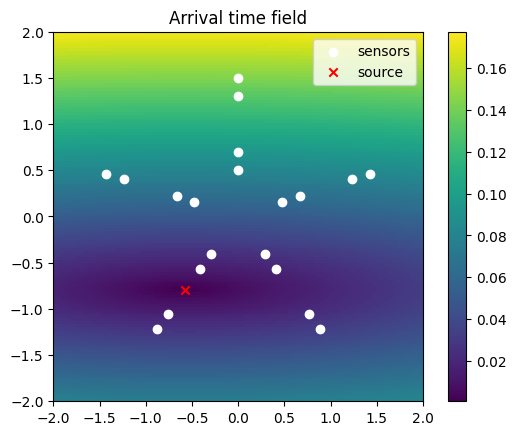

In [5]:
problem = SingleSourceProblem.generate_random_instance(velocity=np.array([1.0, 1.0]))
plot_problem(problem)

This kind of plot is deceitful. By looking at it one may infer that the loss function is very regular and the problem is well conditioned. Experiments have shown that the loss function is not convex, otherwise we would have always convergence.

### Loss landscape

In [6]:
def compute_loss_landscape(problem: SingleSourceProblem, mesh: np.ndarray, loss: AbstractLoss = SquaredLoss()):
    xx, yy = np.meshgrid(mesh, mesh)

    return loss(
        problem,
        np.array([xx, yy]).T
    ).T

In [7]:
def plot_loss(problem: SingleSourceProblem, loss: AbstractLoss = SquaredLoss(), resolution: int = 256):
    mesh = np.linspace(-L, L, num=resolution)
    landscape = compute_loss_landscape(problem, mesh, loss)

    plt.pcolormesh(mesh, mesh, landscape)

    plt.scatter(
        problem.sensor_locations[:,0],
        problem.sensor_locations[:,1],
        marker='o',
        color='w',
        label='sensors'
    )
    plt.scatter(
        problem.source_location[0],
        problem.source_location[1],
        marker='x',
        color='r',
        label='source'
    )

    plt.xlim((-L,L))
    plt.ylim((-L,L))
    plt.title(f"{loss} landscape")
    plt.legend()
    plt.gca().set_aspect('equal')

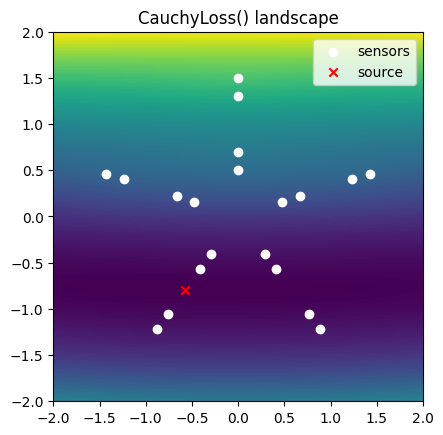

In [8]:
plot_loss(problem, loss=CauchyLoss())

In [9]:
def plot_loss_contour(problem: SingleSourceProblem,
                      loss: AbstractLoss = SquaredLoss(),
                      resolution: int = 256,
                      nlevels: int = 10,
                      lim: float = L):
    mesh = np.linspace(-lim, lim, num=resolution)
    landscape = compute_loss_landscape(problem, mesh, loss)

    min_energy = np.min(landscape)
    max_energy = np.max(landscape)

    energy_levels = min_energy + 2.0**(-np.arange(nlevels)) * (max_energy - min_energy)
    energy_levels = energy_levels[::-1]

    plt.contour(
        mesh,
        mesh,
        landscape,
        levels=energy_levels,
        zorder=0
    )

    plt.scatter(
        problem.source_location[0],
        problem.source_location[1],
        marker='x',
        color='r',
        label='source',
        zorder=10
    )

    plt.xlim((-lim,lim))
    plt.ylim((-lim,lim))
    plt.title(f"{loss} landscape")
    plt.legend()
    plt.gca().set_aspect('equal')

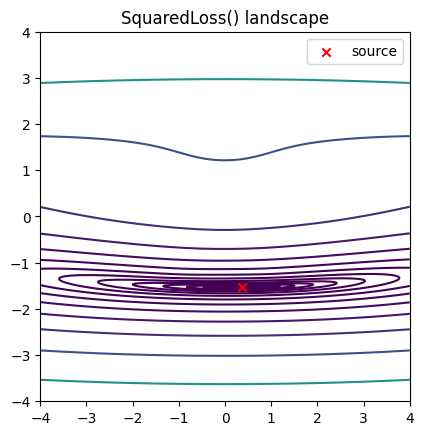

In [10]:
plot_loss_contour(
    SingleSourceProblem.generate_random_instance().get_random_subproblem(20),
    resolution=512,
    nlevels=15,
    lim=4.0
)

The contour plots show:
  * non linearities away from optimal point
  * squished energy levels (ill conditioned)
  * sometimes other minima

# Optimization
As mentioned before, the unperturbed problem is ill conditioned. A (coarse) grid search is used to select a good starting point for the optimization procedure. I expect the technique to reduce the occurrences of:
$$ \mathcal{L}(\mathbf{x}) \quad "small" \quad but \quad || \mathbf{x} - \mathbf{x}_{opt} || \quad "big" $$

In [11]:
from solver import AbstractSolver, LeastSquaresSolver, MinimizeSolver, GoodStartSolver, GridSearchSolver

In [12]:
def sample_optimizer_fails(sensor_sizes: np.array, nruns_per_bin: int, solver: AbstractSolver, error_threshold: float = 1e-3):
    fails = np.zeros(sensor_sizes.shape[0])

    for (i, sensor_size) in enumerate(sensor_sizes):
        for _ in range(nruns_per_bin):
            problem = SingleSourceProblem.generate_random_instance().get_random_subproblem(sensor_size)

            try:
                expected_source_location = solver.solve(
                    problem=problem,
                    x0=np.array([0.0, 0.0])
                ).x
                error = np.linalg.norm(expected_source_location - problem.source_location)

            except ValueError:
                error = np.inf

            if error > error_threshold:
                fails[i] += 1

    return sensor_sizes, fails

In [13]:
def test_optimizer_fails(sensor_sizes: np.array, nruns_per_bin: int, solvers: list[AbstractSolver], error_threshold: float = 1e-3):
    for solver in solvers:
        sensor_sizes, fails = sample_optimizer_fails(sensor_sizes, nruns_per_bin, solver, error_threshold)
        plt.plot(sensor_sizes, fails/nruns_per_bin, label=str(solver))


    plt.xticks(sensor_sizes)
    plt.xlabel('# sensors used')
    plt.ylabel('fail frequency')

    plt.title("Fails in optimization procedure")
    plt.legend()
    plt.show()

/home/matteo/experiments/numerics/radar/loss.py:18: RuntimeWarning: invalid value encountered in divide
  return -diffs / (np.linalg.norm(diffs, axis=1, keepdims=True) * problem.velocity)


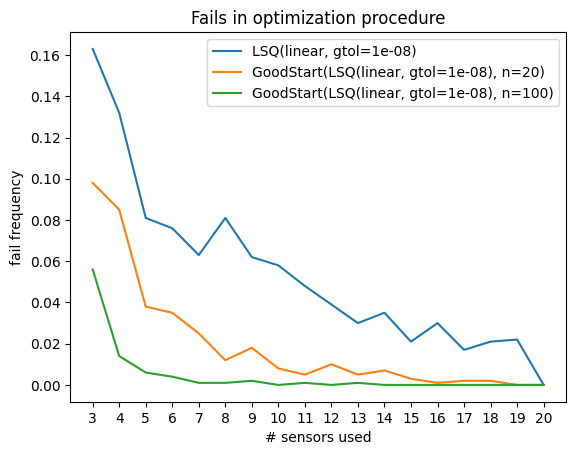

In [14]:
test_optimizer_fails(
    sensor_sizes=np.arange(3, SENSOR_LOCATIONS.shape[0]+1),
    nruns_per_bin=1000,
    solvers=[
        LeastSquaresSolver(),
        GoodStartSolver(LeastSquaresSolver(), resolution=20),
        GoodStartSolver(LeastSquaresSolver(), resolution=100),
    ],
    error_threshold=1e-2
)

Much of the work in this section will be devoted to reduce the fail frequency. 

In [15]:
def plot_solver_result(problem: SingleSourceProblem, solver: AbstractSolver):
    plot_loss(problem)

    expected_source_location = solver.solve(problem, np.array([0.0, 0.0])).x
    plt.scatter(
        expected_source_location[0],
        expected_source_location[1],
        marker='.',
        label='solution'
    )

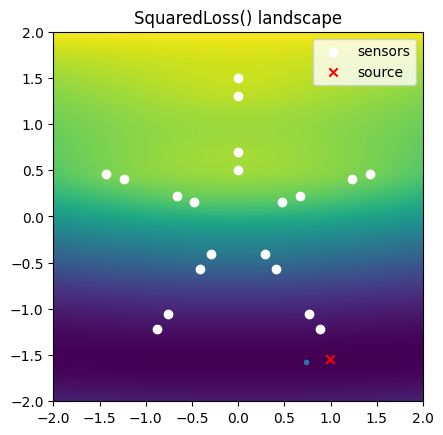

In [16]:
plot_solver_result(
    SingleSourceProblem.generate_random_instance(),
    GridSearchSolver(resolution=20)
)

## Optimization in the presence of outliers

In [17]:
def sample_solver_robustness(outliers: int, sigmas: np.array, nruns_per_bin: int, solver: AbstractSolver):
    errors = np.zeros_like(sigmas)

    for i, sigma in enumerate(sigmas):
        local_errors = np.zeros(nruns_per_bin)

        for j in range(nruns_per_bin):
            problem = SingleSourceProblem.generate_random_instance(
                outliers, sigma
            )

            expected_source_location = solver.solve(
                problem=problem,
                x0=np.array([0.0, 0.0])
            ).x

            local_errors[j] = np.linalg.norm(expected_source_location - problem.source_location)

        errors[i] = np.mean(local_errors)

    return sigmas, errors

In [18]:
def test_solver_robustness(outliers: int, sigmas: np.array, nruns_per_bin: int, solvers: list[AbstractSolver]):
    for solver in solvers:
        sigmas, errors = sample_solver_robustness(outliers, sigmas, nruns_per_bin, solver)
        plt.loglog(sigmas, errors, label=str(solver))

    plt.xlabel('$\\sigma$')
    plt.ylabel('avg abs err')

    plt.title(f"Solver robustness to {outliers}/{SENSOR_LOCATIONS.shape[0]} outliers")
    plt.legend()

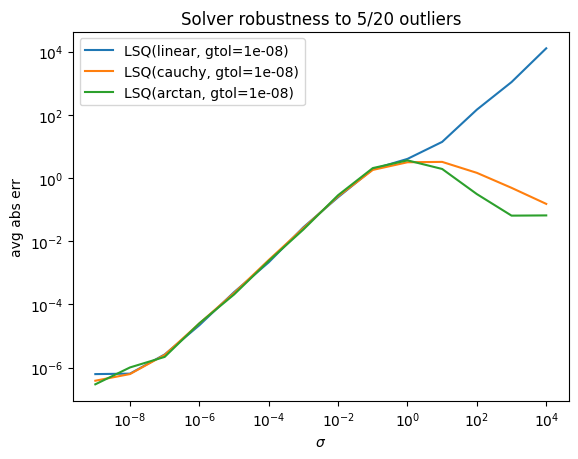

In [19]:
test_solver_robustness(
    outliers=5,
    sigmas=10.0**np.arange(-9, 5),
    nruns_per_bin=200,
    solvers=[
        LeastSquaresSolver('linear'),
        LeastSquaresSolver('cauchy'),
        LeastSquaresSolver('arctan'),
    ]
)